# Ch 9 - Unsupervised Learning Techniques

This notebook contains the code for Ch 9; see the notes on GitHub for more details.

## K-Means Clustering

To start, we will create some artifical cluster data, and then use the k-means algorithm to attempt to define the clusters.

In [1]:
from sklearn.datasets import make_blobs

In [2]:
import numpy as np
np.random.seed(42)

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [3]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [4]:
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

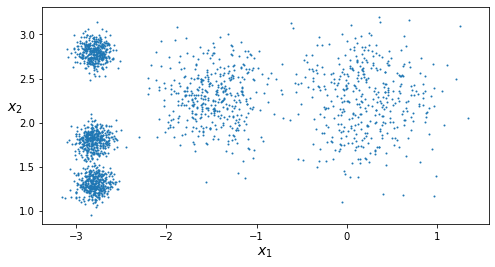

In [5]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

Now that we have our data, let's implement the k-means clustering algorithm!

In [6]:
from sklearn.cluster import KMeans

In [7]:
k = 5
kmeans = KMeans(n_clusters=k)

In [8]:
y_pred = kmeans.fit_predict(X)

By doing this, the k-means algorithm has identified for us five clusters. Each cluster can be identified by its **centroid**:

In [9]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

Since we have specified SKL to look for five clusters, each instance has been assigned to one of these five clusters, which are denoted as 0,1,2,3,4:

In [10]:
y_pred[:10]

array([0, 4, 1, 4, 4, 0, 4, 4, 3, 4])

This means the first instance was assigned to belong in the first cluster (the one with centroid $(-2.80, 1.30)$), the second instance was assigned to the fourth cluster (the one with centroid $(-2.80, 1.80)$), and so on.

In [11]:
kmeans.labels_

array([0, 4, 1, ..., 2, 1, 4])

We note that these assignments are called **labels**, but not in the sense of having a labelled data set!

Finally, we can now use our k-means ML model on new inputs too. A new input is assigned to that cluster to which its centroid is closest to the input.

In [12]:
X_new = np.array([ [0,2], [3,2], [-3,3], [-3, 2.5] ])

In [13]:
kmeans.predict(X_new)

array([1, 1, 2, 2])

These assignments of the four new data points to the clusters make perfect sense when we look at the model's decision boundaries. The decision boundaries form what is called a **Voronoi diagram** (aka: *Voronoi tessellation*).

In [15]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

In [16]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

In [17]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

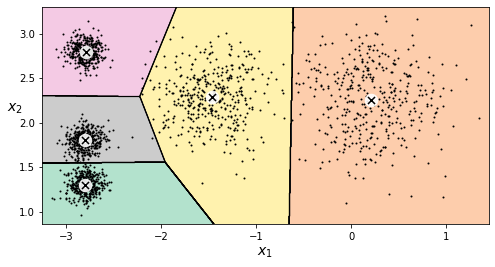

In [18]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

We can compute the distances of any instance to each cluster centroid using the 'transform()' method:

In [19]:
kmeans.transform(X_new)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

This output means that, for example, for the first instance $[0,2]$ has distances:
* 2.81 from the first cluster
* 0.33 from the second cluster,
* 2.90 from the third cluster

and so on.

**Centroid Initialization Methods**

In [20]:
approximate_centroids = np.array([ [-3,3], [-3,2], [-3,1], [-1,2], [0,2] ])

In [21]:
kmeans = KMeans(n_clusters=5, init = approximate_centroids, n_init = 1)

In [24]:
kmeans.fit_predict(X)

array([2, 1, 4, ..., 0, 4, 1])

In [25]:
kmeans.inertia_

211.62337889822362

In [26]:
kmeans.score(X)

-211.6233788982236

**Finding the Optimal Number of Clusters**

One way to get an initial understanding of the optimal number of clusters is to use the "elbow method". We will plot the inertia of various k-means models with respect to the number of clusters, and look at the resulting plot for the elbow:

In [27]:
# Initializing and fitting various k-mean class objects, with different k values

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

In [28]:
# Extracting the inertia of each model

inertias = [model.inertia_ for model in kmeans_per_k]

(1.0, 8.5, 0.0, 1300.0)

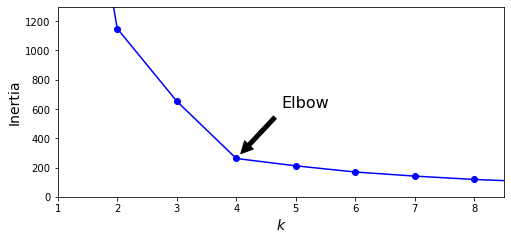

In [29]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

So, we see that the elbow occurs when the number of clusters $k=4$, and this would be a perfectly fine choice for $k$.

We can also plot the various **silhouette scores** for the above k-mean models:

In [31]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [32]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

(1.8, 8.5, 0.55, 0.7)

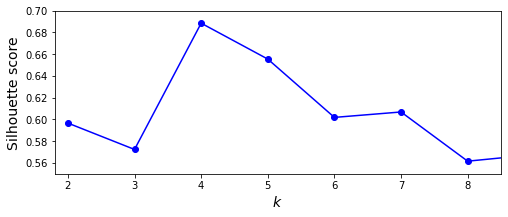

In [33]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

Here, we can see that $k=4$ does indeed yield the highest silhouette score. But even moreso, this plot shows use that $k=5$ is also a decent choice, and this fact is **not present in the previous plot**!!!

Finally, we can also look at the **silhouette diagram** as well:

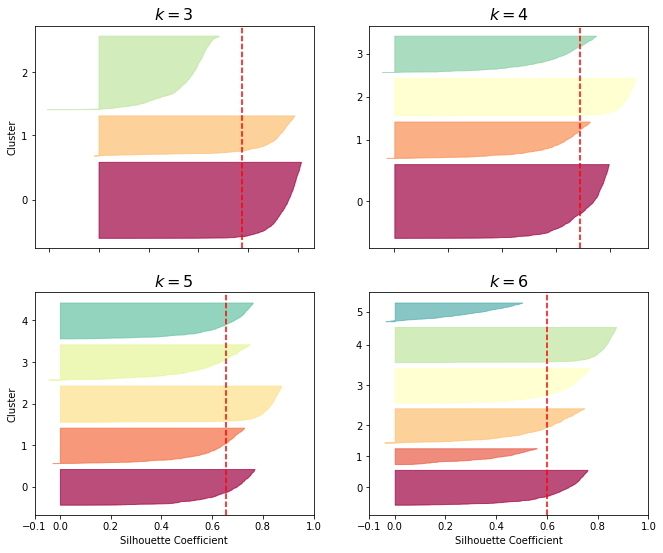

In [35]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)